# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3073L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3073L)
Test labels shape:  (1000L,)
dev data shape:  (500L, 3073L)
dev labels shape:  (500L,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.410674
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *When the weights are close to zero, all the weighted sums are close to zero as well. Therefore, the loss for each example is equal to (e^0/(C*e^0)), which in this example is 1/10 and therefore the total loss becomes approximately (n*log(0.1))/n*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
# print 'hello'
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.793018 analytic: 1.793017, relative error: 2.754435e-08
numerical: -0.753952 analytic: -0.753952, relative error: 2.194518e-08
numerical: -0.172975 analytic: -0.172975, relative error: 4.178998e-07
numerical: 1.139248 analytic: 1.139248, relative error: 3.264366e-09
numerical: 2.200381 analytic: 2.200381, relative error: 3.802898e-09
numerical: 4.255194 analytic: 4.255194, relative error: 1.429666e-08
numerical: 1.346117 analytic: 1.346117, relative error: 1.835769e-08
numerical: -2.239723 analytic: -2.239723, relative error: 2.661443e-09
numerical: 5.223461 analytic: 5.223461, relative error: 1.959102e-08
numerical: 2.655221 analytic: 2.655221, relative error: 1.746622e-08
numerical: 1.267548 analytic: 1.267548, relative error: 2.021007e-08
numerical: 0.099458 analytic: 0.099458, relative error: 7.769874e-08
numerical: -2.524927 analytic: -2.524927, relative error: 1.089272e-08
numerical: -0.057054 analytic: -0.057054, relative error: 2.570414e-07
numerical: 2.293570 anal

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.410674e+00 computed in 0.548000s
vectorized loss: 2.410674e+00 computed in 0.030000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-6]
regularization_strengths = [7e3, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for i in range(20):
    lr = np.random.uniform(learning_rates[0], learning_rates[1])
    reg = np.random.uniform(regularization_strengths[0], regularization_strengths[1])
    model = Softmax()
    losses = model.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1000, verbose=False)
    y_train_pr = model.predict(X_train)
    train_acc = np.mean(y_train_pr == y_train)
    y_val_pr = model.predict(X_val)
    val_acc = np.mean(y_val_pr == y_val)
    print i
#     result.append
    if val_acc > best_val:
        best_val = val_acc
        best_softmax = model
    key = (lr, reg)
    value = (train_acc, val_acc)
    results[key] = value
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
lr 1.026335e-07 reg 1.707205e+04 train accuracy: 0.321816 val accuracy: 0.302000
lr 8.933779e-07 reg 2.192054e+04 train accuracy: 0.343755 val accuracy: 0.351000
lr 1.170932e-06 reg 1.900757e+04 train accuracy: 0.347143 val accuracy: 0.364000
lr 1.224016e-06 reg 1.538458e+04 train accuracy: 0.348204 val accuracy: 0.358000
lr 1.402747e-06 reg 3.585973e+04 train accuracy: 0.331143 val accuracy: 0.347000
lr 2.003043e-06 reg 3.492239e+04 train accuracy: 0.317429 val accuracy: 0.325000
lr 2.188045e-06 reg 4.704942e+04 train accuracy: 0.306776 val accuracy: 0.337000
lr 2.880040e-06 reg 9.454362e+03 train accuracy: 0.352939 val accuracy: 0.361000
lr 3.202189e-06 reg 2.746148e+04 train accuracy: 0.315653 val accuracy: 0.319000
lr 3.478292e-06 reg 2.306131e+04 train accuracy: 0.289204 val accuracy: 0.303000
lr 3.781262e-06 reg 9.912946e+03 train accuracy: 0.359694 val accuracy: 0.382000
lr 3.941638e-06 reg 3.809245e+04 train accuracy: 0.289327 v

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.352000


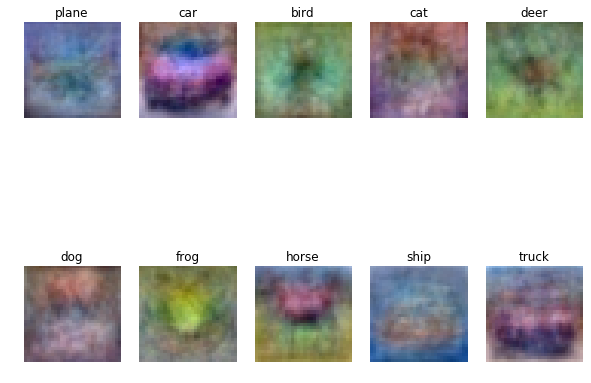

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])